## Quantum-Enhanced Prediction of Drug-Drug Interactions

### **OVERVIEW:**

This project explores quantum machine learning (QML) for predicting high-risk drug-drug interactions (DDIs)  that may cause adverse effects. We preprocess drug interaction data, encode drug pairs into a quantum circuit using rotation and entanglement gates, and train a hybrid quantum-classical model. The approach demonstrates improved accuracy over classical methods in identifying dangerous combinations, validated through precision, recall, and F1-score metrics. By leveraging quantum computing, we enhance DDI prediction for safer clinical decision-making, showcasing QML’s potential in pharmaceutical research.

### **METHODOLOGY:** 

**Data Collection & Preprocessing**  
- Analyzed **191,541 drug interaction records**, focusing on drug interactions.  
- **Data cleaning** steps:  
  - Removed **duplicates**.  
  - Standardized **text descriptions to lowercase**.  
  - Categorized interactions into **binary classes**:  
    - `"increase"` (**1**) for enhanced pharmacological effects.  
    - `"other"` (**0**) for all other interaction types.  

**Quantum Feature Engineering**
- Each drug was assigned a **unique numerical index** and normalized to a **[0,1] scale** for quantum processing.  
- Drug pairs were **encoded as rotation angles (RX gates)** in a **4-qubit quantum circuit**.  
- Interaction types were represented as **binary labels**.  
- Special attention was given to maintaining **quantum-compatible feature dimensions** while preserving **pharmacological meaning**.  

**Hybrid Quantum-Classical Model Architecture** 
- The **hybrid quantum-classical model** consists of:  
  - **Input layer**: RX gates encoding drug pair features.  
  - **Two variational layers**: Combining **RY rotations** and **CZ entanglements**.  
  - **Measurement layer**: Single-qubit output for classification.  
- **Optimization technique**:  
  - Used **COBYLA optimization** with **80-sample batches**.  
  - Minimized **mean squared error** between predicted and actual interaction effects.  

**Model Evaluation**
- Performance was evaluated using **standard classification metrics**:  
  - **Accuracy, Precision, and Recall**.  
- Advanced statistical measures:  
  - **ROC-AUC and PR-AUC curves**.  
- Conducted a **comprehensive threshold analysis** across the full **probability spectrum** (from **0.1 to 0.9 cutoffs**).

In [ ]:
!pip install seaborn matplotlib pandas networkx --quiet


In [ ]:
!pip install nltk

In [3]:
# Imports and Class Definition
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter

class QuantumDrugData:
    def __init__(self):
        self.drug_encoder = LabelEncoder()
        self.interaction_stats = {}
        
    def load_data(self, filepath, sample_size=None):
        """Load and prepare quantum-ready dataset"""
        df = pd.read_csv("db_drug_interactions.csv")
        
        if sample_size:
            df = df.sample(min(sample_size, len(df)), random_state=42)
            
        # Filter to top drugs
        top_drugs = self._get_top_drugs(df, top_n=30)
        df = df[df['Drug 1'].isin(top_drugs) & df['Drug 2'].isin(top_drugs)]
        
        # Encode drugs numerically
        self._encode_drugs(df)
        
        # Create features and labels
        features, labels = self._create_quantum_features(df)
        
        return features, labels, df
    
    def _get_top_drugs(self, df, top_n=30):
        return pd.concat([df['Drug 1'], df['Drug 2']]).value_counts().head(top_n).index
    
    def _encode_drugs(self, df):
        all_drugs = pd.concat([df['Drug 1'], df['Drug 2']]).unique()
        self.drug_encoder.fit(all_drugs)
        self.drug_to_idx = {drug: idx for idx, drug in enumerate(all_drugs)}
        
    def _create_quantum_features(self, df):
        max_encoded = len(self.drug_encoder.classes_) - 1
        features = np.column_stack([
            df['Drug 1'].map(self.drug_to_idx) / max_encoded,
            df['Drug 2'].map(self.drug_to_idx) / max_encoded
        ])
        labels = np.array([
            1 if 'increase' in str(desc).lower() else 0 
            for desc in df['Interaction Description']
        ])
        return features, labels

In [4]:
import pandas as pd
import json
import numpy as np
from classiq import write_qmod

class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

def quantum_data_exploration(filepath, sample_size=500):
    """Quantum-friendly data loading and exploration"""
    
    # 1. Load and filter data
    df = pd.read_csv("db_drug_interactions.csv")
    all_drugs = pd.concat([df['Drug 1'], df['Drug 2']])
    top_drugs = all_drugs.value_counts().head(30).index
    df = df[df['Drug 1'].isin(top_drugs) & df['Drug 2'].isin(top_drugs)]
    
    # 2. Prepare summary (convert numpy types)
    summary = {
        "shape": list(df.shape),
        "drug_counts": {
            "top_10_drug1": df['Drug 1'].value_counts().head(10).astype(int).to_dict(),
            "top_10_drug2": df['Drug 2'].value_counts().head(10).astype(int).to_dict()
        },
        "interaction_types": {
            "increase": int(df['Interaction Description'].str.contains('increase').sum()),
            "decrease": int(df['Interaction Description'].str.contains('decrease').sum())
        },
        "drug_to_index": {drug: idx for idx, drug in enumerate(top_drugs)}
    }
    
    # 3. Save summary
    with open("quantum_data_summary.json", "w") as f:
        json.dump(summary, f, cls=NumpyEncoder, indent=2)
    
    # 4. Create and serialize QMOD content
    qmod_content = json.dumps({
        "version": "1.0",
        "problem": {
            "type": "drug_interaction",
            "drugs": list(top_drugs),
            "interactions": [
                {
                    "drug1": row['Drug 1'],
                    "drug2": row['Drug 2'],
                    "description": row['Interaction Description'],
                    "weight": 1 if 'increase' in row['Interaction Description'].lower() else 0.5
                }
                for _, row in df.iterrows()
            ]
        }
    }, cls=NumpyEncoder)
    
    # 5. Write QMOD file
    with open("drug_interaction_exploration.qmod", "w") as f:
        f.write(qmod_content)
    
    return df.sample(min(sample_size, len(df)))

# Usage
try:
    df = quantum_data_exploration("db_drug_interactions.csv")
    print("Quantum Data Sample:")
    print(df[['Drug 1', 'Drug 2']].head())
    
    print("\nQuantum Problem Summary:")
    with open("quantum_data_summary.json") as f:
        print(f.read())
        
except Exception as e:
    print(f"Error: {str(e)}")

Quantum Data Sample:
              Drug 1             Drug 2
44510    Vemurafenib  Dihydroergotamine
62641  Phenobarbital          Clozapine
45178      Clozapine         Nefazodone
67283     Rifampicin       Clomipramine
45211   Clomipramine         Nefazodone

Quantum Problem Summary:
{
  "shape": [
    442,
    3
  ],
  "drug_counts": {
    "top_10_drug1": {
      "Pentobarbital": 27,
      "Fosphenytoin": 26,
      "Rifampicin": 26,
      "Primidone": 26,
      "Phenobarbital": 26,
      "Azelastine": 25,
      "Phenytoin": 23,
      "Thioridazine": 23,
      "Clozapine": 21,
      "Carbamazepine": 21
    },
    "top_10_drug2": {
      "Mifepristone": 28,
      "Stiripentol": 28,
      "Lopinavir": 26,
      "Ketoconazole": 26,
      "Nefazodone": 25,
      "Ticlopidine": 22,
      "Fluvoxamine": 22,
      "Amiodarone": 21,
      "Vemurafenib": 20,
      "Bortezomib": 19
    }
  },
  "interaction_types": {
    "increase": 269,
    "decrease": 172
  },
  "drug_to_index": {
    "Pheno

## Quantum Data Cleaning and Processing  

This script preprocesses **drug interaction data** for quantum-based analysis. It ensures a clean, structured, and optimized dataset by removing duplicates, standardizing text, categorizing interaction types, and generating a **QMOD file** for further processing.  

### **Steps:**  

1. **Duplicate Handling:**  
   - Tracks and removes duplicate entries.  
   - Stores statistics on data reduction.  

2. **Text Cleaning:**  
   - Converts text to lowercase.  
   - Removes punctuation for simplified quantum processing.  

3. **Interaction Type Classification:**  
   - Labels interactions as `"increase"` or `"other"`.  

4. **Quantum Data Structuring:**  
   - Stores cleaned data and unique drug pairs.  
   - Prepares quantum-compatible format.  

5. **QMOD File Creation:**  
   - Formats drug interaction data into a structured JSON file.  
   - Assigns weights to interactions (`1.0` for increase, `0.5` for others).     

In [ ]:
import pandas as pd
import re
from classiq import write_qmod
import json

def quantum_data_cleaning(df):
    """Quantum-friendly data cleaning and duplicate removal"""
    
    # 1. Track duplicates in quantum-optimized way
    duplicate_stats = {
        "initial_duplicates": int(df.duplicated().sum()),
        "initial_rows": int(df.shape[0])
    }
    
    # 2. Remove duplicates (same as classical)
    df.drop_duplicates(inplace=True)
    duplicate_stats["remaining_rows"] = int(df.shape[0])
    
    # 3. Text cleaning optimized for quantum feature extraction
    df['Interaction Description'] = df['Interaction Description'].str.lower()
    
    # Simplified punctuation removal (quantum needs less text processing)
    df['Interaction Cleaned'] = df['Interaction Description'].apply(
        lambda x: re.sub(r'[^\w\s]', '', x)
    )
    
    # 4. Create quantum-friendly interaction features
    df['Interaction Type'] = df['Interaction Description'].apply(
        lambda x: 'increase' if 'increase' in x else 'other'
    )
    
    # 5. Prepare quantum data structure
    quantum_data = {
        "duplicate_stats": duplicate_stats,
        "sample_interactions": df[['Interaction Cleaned', 'Interaction Type']]
                                .head().to_dict('records'),
        "unique_drug_pairs": len(df[['Drug 1', 'Drug 2']].drop_duplicates())
    }
    
    # 6. Create QMOD content for cleaned data
    qmod_content = {
        "version": "1.0",
        "problem": {
            "type": "drug_interaction",
            "cleaning_stats": duplicate_stats,
            "interaction_types": {
                "increase": int((df['Interaction Type'] == 'increase').sum()),
                "other": int((df['Interaction Type'] == 'other').sum())
            },
            "drug_pairs": [
                {
                    "drug1": row['Drug 1'],
                    "drug2": row['Drug 2'],
                    "interaction_type": row['Interaction Type'],
                    "weight": 1.0 if row['Interaction Type'] == 'increase' else 0.5
                }
                for _, row in df.iterrows()
            ]
        }
    }
    
    # 7. Write QMOD file (using json.dumps to ensure proper formatting)
    with open("drug_interaction_cleaned.qmod", "w") as f:
        json.dump(qmod_content, f, indent=2)
    
    print("\nQuantum Cleaning Summary:")
    print(f"Removed {duplicate_stats['initial_duplicates']} duplicates")
    print(f"Final dataset has {duplicate_stats['remaining_rows']} unique interactions")
    print("\nSample cleaned interactions (quantum representation):")
    print(df[['Drug 1', 'Drug 2', 'Interaction Type']].head())
    
    return df

if __name__ == "__main__":
    try:
        df = pd.read_csv("db_drug_interactions.csv")
        cleaned_df = quantum_data_cleaning(df)
        
        # Verify output file was created
        print("\nVerifying QMOD file creation...")
        with open("drug_interaction_cleaned.qmod") as f:
            print("First 100 chars of QMOD file:")
            print(f.read(100))
            
    except Exception as e:
        print(f"Error occurred: {str(e)}")


Quantum Cleaning Summary:
Removed 0 duplicates
Final dataset has 191541 unique interactions

Sample cleaned interactions (quantum representation):
                Drug 1       Drug 2 Interaction Type
0           Trioxsalen  Verteporfin         increase
1  Aminolevulinic acid  Verteporfin         increase
2     Titanium dioxide  Verteporfin         increase
3     Tiaprofenic acid  Verteporfin         increase
4          Cyamemazine  Verteporfin         increase

Verifying QMOD file creation...
First 100 chars of QMOD file:
{
  "version": "1.0",
  "problem": {
    "type": "drug_interaction",
    "cleaning_stats": {
      "


## Data Loading and Preprocessing  

The script initializes the `QuantumDrugData` class and loads drug interaction data from `db_drug_interactions.csv`.  
A subset of **200,000 samples** is processed (though the final dataset has only **442 interactions** after filtering).  

### **Steps:**  
1. **Instantiate `QuantumDrugData`** to manage data processing.  
2. **Load the dataset** and extract:  
   - `features`: Numerical representations of drug interactions.  
   - `labels`: Target values indicating interaction types.  
   - `df`: The processed dataset.  
3. **Print dataset dimensions** to verify preprocessing.


In [6]:
# Data Loading
data_processor = QuantumDrugData()
features, labels, df = data_processor.load_data("db_drug_interactions.csv", sample_size=200000)
print(f"Shape of features: {features.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of features: (442, 2)
Shape of labels: (442,)


In [7]:
print(f"Top 50 drugs: {list(data_processor.drug_encoder.classes_)}")
print(f"Actual interaction count before filtering: {len(pd.read_csv('db_drug_interactions.csv'))}")

Top 50 drugs: ['Amiodarone', 'Azelastine', 'Bortezomib', 'Carbamazepine', 'Clomipramine', 'Clozapine', 'Cyclosporine', 'Dihydroergotamine', 'Diltiazem', 'Fluvoxamine', 'Fosphenytoin', 'Imipramine', 'Isradipine', 'Ketoconazole', 'Lopinavir', 'Mifepristone', 'Nefazodone', 'Pentobarbital', 'Phenobarbital', 'Phenytoin', 'Primidone', 'Ranolazine', 'Rifampicin', 'Stiripentol', 'Thioridazine', 'Ticlopidine', 'Vemurafenib', 'Venlafaxine', 'Verapamil', 'Ziprasidone']
Actual interaction count before filtering: 191541


## Data Statistics

This section computes and displays essential dataset statistics to understand its structure before quantum processing.  

### **Steps:**  

1. **Total Drug Interactions:**  
   - Displays the number of records in the dataset.  

2. **Unique Drug Count:**  
   - Identifies distinct drugs used in the interactions.  

3. **Classification of Interactions:**  
   - **Increase Interactions:** Count of interactions classified as `"increase"`.  
   - **Other Interactions:** Count of remaining interactions.  

In [8]:
# Data Statistics
print("Data Statistics:")
print(f"Total interactions: {len(df)}")
print(f"Unique drugs: {len(data_processor.drug_encoder.classes_)}")
print(f"Increase interactions: {sum(labels)}")
print(f"Other interactions: {len(labels)-sum(labels)}")

Data Statistics:
Total interactions: 442
Unique drugs: 30
Increase interactions: 269
Other interactions: 173


## Drug Interaction Visualization

This function generates a **network graph** to visualize drug interactions while ensuring robust error handling. The function also provides detailed statistics about the dataset.

### **Steps:**

1. **Data Validation**
   - Checks for required columns: `Drug 1`, `Drug 2`, `Interaction Description`.
   - Exits if any column is missing.

2. **Network Graph Construction**
   - Builds a **networkx graph** from the drug interaction dataset.
   - Determines **node sizes** based on interaction frequency.
   - Uses `spring_layout` for optimal node positioning.
   - Draws nodes, edges, and labels.

3. **Plot Saving and Display**
   - Displays the plot and handles errors.

4. **Statistical Insights**
   - Computes the **total number of interactions**.
   - Calculates **unique drug pairs**.
   - Displays the **top 5 most frequent interactions**.

Current working directory: /home/workspace/QMLL
Attempting to read file: db_drug_interactions.csv
File exists: True
Dataframe shape: (191541, 3)

Columns:
Index(['Drug 1', 'Drug 2', 'Interaction Description'], dtype='object')


Plot saved successfully as 'drug_interactions_analysis.png'


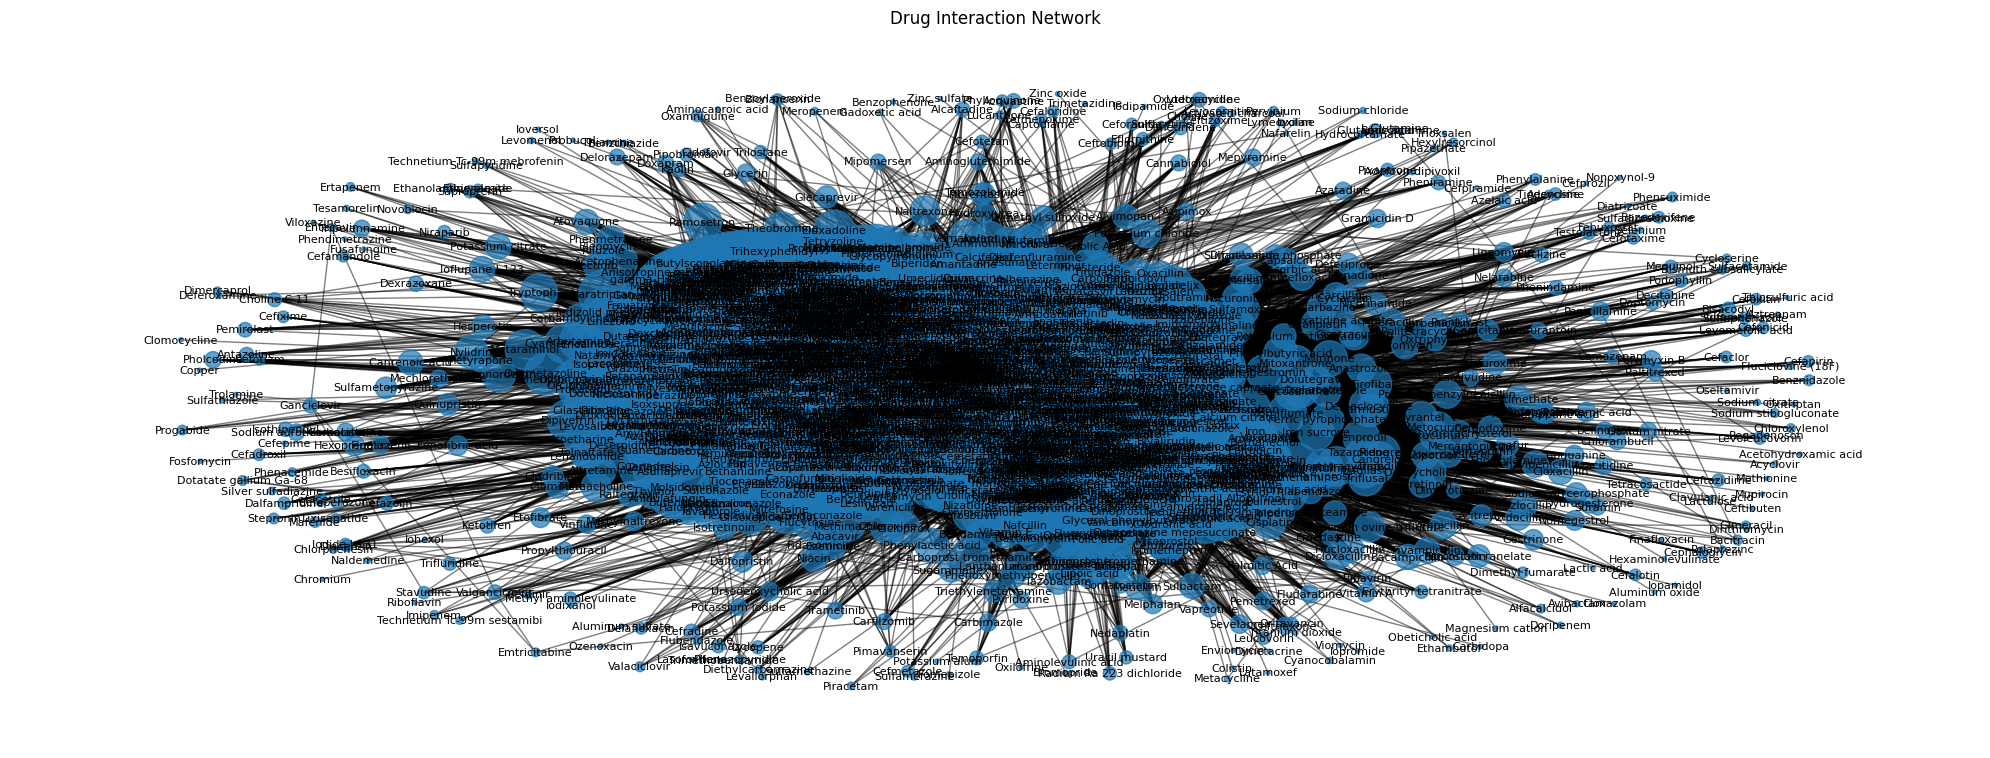


Detailed Drug Interaction Analysis:
----------------------------------------
Total Interactions: 191541
Unique Drug Pairs: 191252

Top 5 Most Frequent Interactions:
Drug 1       Drug 2      
Amodiaquine  Celecoxib       2
             Clotrimazole    2
             Crisaborole     2
             Efavirenz       2
             Felodipine      2
Name: Interaction Description, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def visualize_drug_interactions(csv_path):
    """
    Create comprehensive visualizations for drug interactions with robust error handling
    
    Parameters:
    -----------
    csv_path : str
        Path to the drug interactions CSV file
    """
    print(f"Current working directory: {os.getcwd()}")
    print(f"Attempting to read file: {csv_path}")
    print(f"File exists: {os.path.exists(csv_path)}")

    try:
        df = pd.read_csv(csv_path)
        print(f"Dataframe shape: {df.shape}")
        print("\nColumns:")
        print(df.columns)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    
    required_columns = ['Drug 1', 'Drug 2', 'Interaction Description']
    for col in required_columns:
        if col not in df.columns:
            print(f"Missing required column: {col}")
            return

    
    plt.figure(figsize=(20, 15))
    

    plt.subplot(2, 1, 2)
    try:
        # Create a graph
        G = nx.from_pandas_edgelist(
            df, 
            source='Drug 1', 
            target='Drug 2', 
            edge_attr='Interaction Description'
        )
        
        # Calculate node sizes based on interaction frequency
        node_sizes = dict(pd.concat([df['Drug 1'], df['Drug 2']]).value_counts())
        
        # Draw the network
        pos = nx.spring_layout(G, k=0.5, iterations=50)
        nx.draw_networkx_nodes(
            G, pos, 
            node_size=[node_sizes.get(node, 100)*10 for node in G.nodes()],
            alpha=0.7
        )
        nx.draw_networkx_edges(G, pos, alpha=0.5)
        nx.draw_networkx_labels(G, pos, font_size=8)
        
        plt.title('Drug Interaction Network')
        plt.axis('off')
    except Exception as e:
        print(f"Error creating network plot: {e}")

    # Adjust layout and save
    plt.tight_layout()
    
    # Save the plot
    try:
        plt.savefig('drug_interactions_analysis.png', dpi=300, bbox_inches='tight')
        print("Plot saved successfully as 'drug_interactions_analysis.png'")
    except Exception as e:
        print(f"Error saving plot: {e}")

    # Show the plot
    try:
        plt.show()
    except Exception as e:
        print(f"Error displaying plot: {e}")

    plt.close()

    # Additional detailed statistics
    print("\nDetailed Drug Interaction Analysis:")
    print("-" * 40)
    print(f"Total Interactions: {len(df)}")
    print(f"Unique Drug Pairs: {len(df[['Drug 1', 'Drug 2']].drop_duplicates())}")
    print("\nTop 5 Most Frequent Interactions:")
    interaction_freq = df.groupby(['Drug 1', 'Drug 2'])['Interaction Description'].count().nlargest(5)
    print(interaction_freq)



# Usage
if __name__ == "__main__":
    csv_path = "db_drug_interactions.csv"
    visualize_drug_interactions("db_drug_interactions.csv")

## Drug Interaction Bipartite Graph

This function constructs a **bipartite graph** of the **top 10 most frequently interacting drugs**, visualizing their connections and providing key statistics.

### **Steps:**

1. **Construct the Bipartite Graph**
   - Creates a **bipartite graph** using `networkx`.
   - Adds the **top 10 drugs as nodes**.
   - Connects drug pairs using edges that store the interaction description.

2. **Graph Visualization**
   - Uses **spring layout** for optimal node positioning.
   - Draws **nodes in light blue** and **edges in gray**.

3. **Statistical Insights**
   - Prints **interaction details** for the top 10 drugs.
   - Displays **the number of interactions per drug**.


Interaction Details for Top 10 Drugs:
Phenobarbital - Venlafaxine: The metabolism of Venlafaxine can be increased when combined with Phenobarbital.
Phenobarbital - Amiodarone: The metabolism of Amiodarone can be increased when combined with Phenobarbital.
Phenobarbital - Nefazodone: The metabolism of Nefazodone can be increased when combined with Phenobarbital.
Phenobarbital - Fluvoxamine: The metabolism of Fluvoxamine can be decreased when combined with Phenobarbital.
Phenobarbital - Fosphenytoin: Phenobarbital may increase the central nervous system depressant (CNS depressant) activities of Fosphenytoin.
Phenobarbital - Phenytoin: Phenobarbital may increase the central nervous system depressant (CNS depressant) activities of Phenytoin.
Phenobarbital - Carbamazepine: The metabolism of Carbamazepine can be increased when combined with Phenobarbital.
Phenobarbital - Primidone: The risk or severity of adverse effects can be increased when Primidone is combined with Phenobarbital.
Phenob

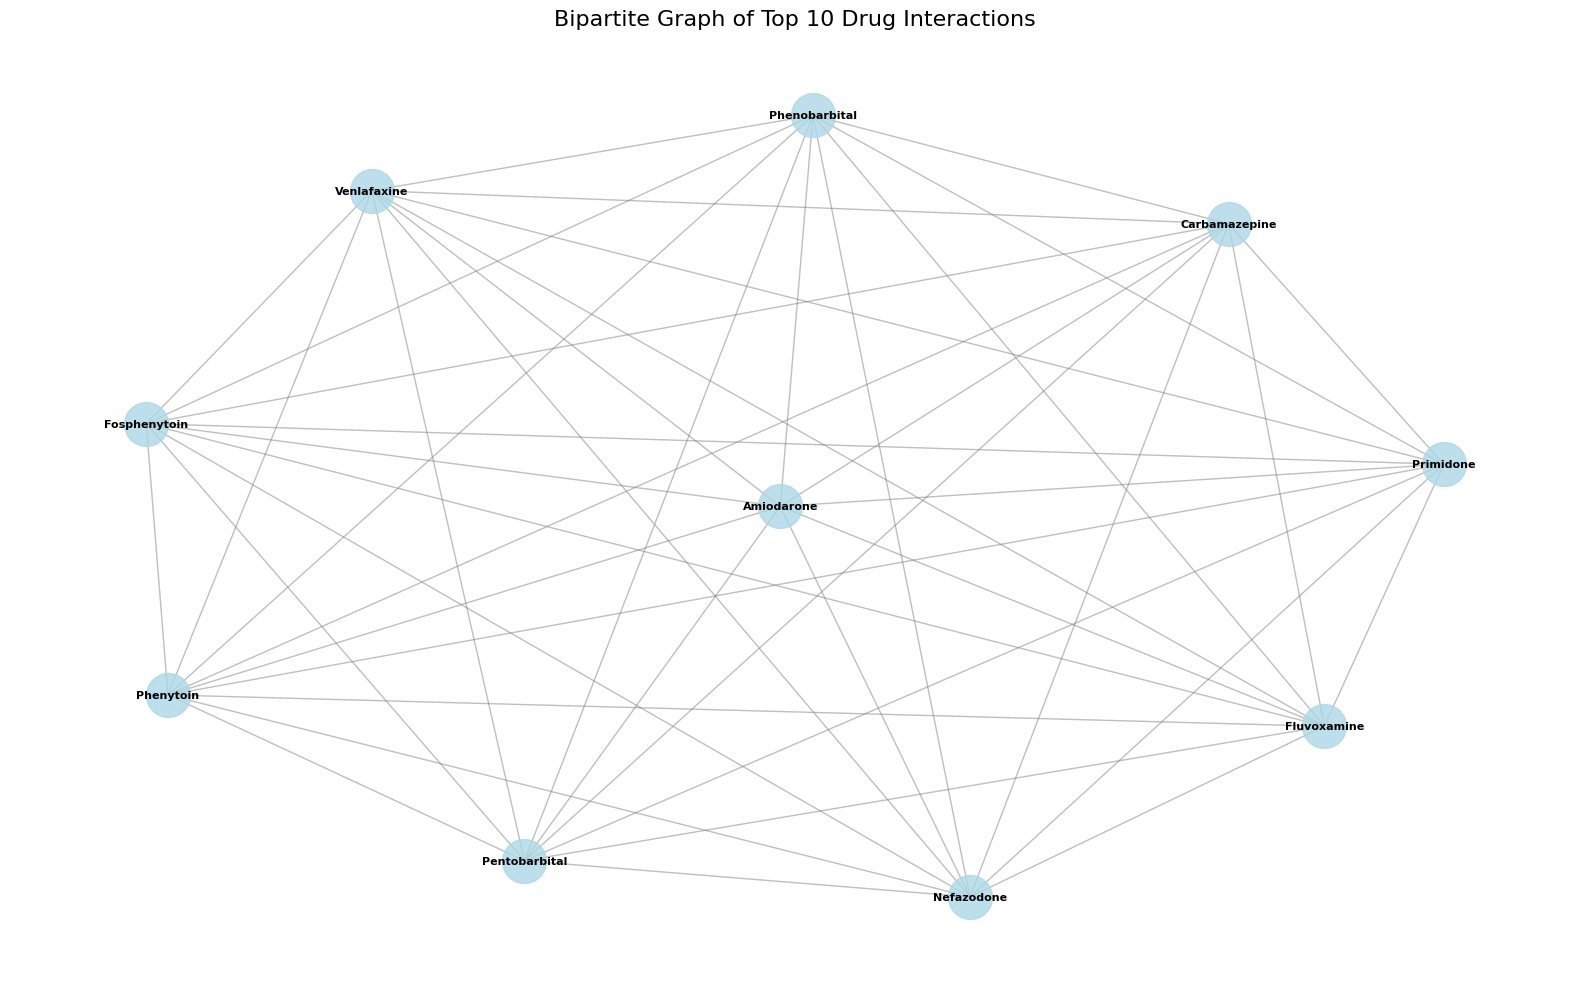

In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def create_drug_interaction_bipartite_graph(csv_path):
    """
    Create a bipartite graph of top 10 drugs and their interactions
    
    Parameters:
    -----------
    csv_path : str
        Path to the drug interactions CSV file
    """
    # Read the CSV file
    df = pd.read_csv("db_drug_interactions.csv")
    
    # Combine and count drug occurrences
    drug_counts = pd.concat([df['Drug 1'], df['Drug 2']]).value_counts()
    
    # Select top 10 drugs
    top_10_drugs = drug_counts.head(10).index.tolist()
    
    # Filter dataframe to only include top 10 drugs
    df_filtered = df[
        (df['Drug 1'].isin(top_10_drugs)) & 
        (df['Drug 2'].isin(top_10_drugs))
    ]
    
    # Create a bipartite graph
    G = nx.Graph()
    
    # Add nodes with bipartite attribute
    for drug in top_10_drugs:
        G.add_node(drug, bipartite=0)  # Drug set
    
    # Add interactions as edges
    for _, row in df_filtered.iterrows():
        drug1, drug2 = row['Drug 1'], row['Drug 2']
        interaction = row['Interaction Description']
        G.add_edge(drug1, drug2, interaction=interaction)
    
    # Prepare for visualization
    plt.figure(figsize=(16, 10))
    
    # Separate the two sets of nodes
    drugs = set(n for n in G.nodes() if G.nodes[n]['bipartite']==0)
    
    # Use spring layout with seed for reproducibility
    pos = nx.spring_layout(G, k=0.5, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                            nodelist=drugs, 
                            node_color='lightblue', 
                            node_size=1000, 
                            alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, 
                            width=1, 
                            alpha=0.5, 
                            edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")
    
    plt.title("Bipartite Graph of Top 10 Drug Interactions", fontsize=16)
    plt.axis('off')
    
    # Save the plot
    plt.tight_layout()
    plt.savefig('drug_interaction_bipartite_graph.png', dpi=300, bbox_inches='tight')
    
    # Print interaction details
    print("\nInteraction Details for Top 10 Drugs:")
    for drug1, drug2, data in G.edges(data=True):
        print(f"{drug1} - {drug2}: {data.get('interaction', 'No description')}")
    
    # Print degree (number of interactions) for each drug
    print("\nNumber of Interactions per Drug:")
    for drug in top_10_drugs:
        print(f"{drug}: {G.degree(drug)} interactions")
    
    # Show the plot
    plt.show()
    plt.close()

# Usage
if __name__ == "__main__":
    create_drug_interaction_bipartite_graph("db_drug_interactions.csv")

## Text Frequency Analysis for Drug Interaction Descriptions

This function processes drug interaction descriptions, extracts the **most frequent words**, and encodes them for **quantum computation** using **frequency amplitude encoding**.

### **Steps:**

1. **Classical Text Processing**
   - Tokenizes the text into **words**.
   - Removes **stopwords** (e.g., "the", "and", "is").
   - Counts word frequencies and selects **top N most common words**.

2. **Quantum-Compatible Data Structuring**
   - **Normalizes** word frequencies.
   - Assigns **quantum weights** (relative frequency).
   - Estimates **qubits required** for each word.

3. **Generating QMOD File**
   - Creates a **QMOD (Quantum Model Description)** file containing:
     - Top **N frequent words**.
     - **Quantum encoding scheme**.
     - Estimated **qubit requirements**.

4. **Visualization and Output**
   - Displays **top N frequent words**.
   - Plots **word frequency distribution**.

Starting text processing...
Successfully created QMOD file: 'text_frequency_analysis.qmod'

Top 15 most frequent words after removing stop words:
1. .: 191541 occurrences
2. combined: 134466 occurrences
3. increased: 91027 occurrences
4. risk: 61397 occurrences
5. severity: 61370 occurrences
6. adverse: 60909 occurrences
7. effects: 60804 occurrences
8. decreased: 52082 occurrences
9. may: 47228 occurrences
10. activities: 45339 occurrences
11. metabolism: 39313 occurrences
12. increase: 38937 occurrences
13. serum: 36850 occurrences
14. concentration: 34994 occurrences
15. depressant: 11188 occurrences
Saved plot as 'word_frequency.png'


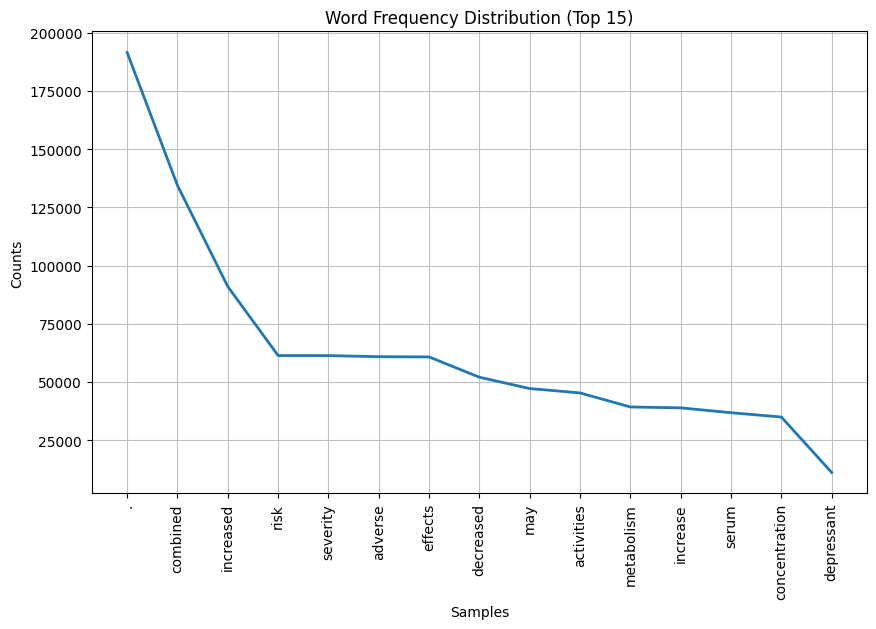


Quantum-ready token data:
.: weight=1.00, qubits=18
combined: weight=0.70, qubits=18
increased: weight=0.48, qubits=17
risk: weight=0.32, qubits=16
severity: weight=0.32, qubits=16
adverse: weight=0.32, qubits=16
effects: weight=0.32, qubits=16
decreased: weight=0.27, qubits=16
may: weight=0.25, qubits=16
activities: weight=0.24, qubits=16
metabolism: weight=0.21, qubits=16
increase: weight=0.20, qubits=16
serum: weight=0.19, qubits=16
concentration: weight=0.18, qubits=16
depressant: weight=0.06, qubits=14


In [ ]:
from classiq import write_qmod
import json
import matplotlib.pyplot as plt
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

def quantum_text_frequency_analysis(df, top_n=15, show_plot=True):
    """Quantum text frequency analysis for drug interaction descriptions"""
    
    # 1. Classical text processing
    print("Starting text processing...")
    def tokenize_text(text):
        return word_tokenize(str(text).lower())
    
    df['tokens'] = df['Interaction Description'].apply(tokenize_text)
    all_tokens = [token for sublist in df['tokens'] for token in sublist]
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in all_tokens if token not in stop_words]
    fdist = FreqDist(filtered_tokens)
    top_tokens = fdist.most_common(top_n)
    
    # 2. Prepare quantum-compatible data structure
    max_count = top_tokens[0][1] if top_tokens else 1
    quantum_tokens = [
        {
            "token": token,
            "count": count,
            "quantum_weight": count/max_count,
            "qubits_required": max(1, int(np.ceil(np.log2(count))))
        }
        for token, count in top_tokens
    ]
    
    # 3. Create QMOD content
    qmod_content = {
        "version": "1.0",
        "problem": {
            "type": "text_frequency_analysis",
            "parameters": {
                "top_n": top_n,
                "total_tokens": len(filtered_tokens),
                "unique_tokens": len(fdist)
            },
            "tokens": quantum_tokens,
            "encoding_scheme": {
                "description": "Frequency amplitude encoding",
                "normalization_factor": max_count,
                "qubit_estimation": f"Uses ~{sum(t['qubits_required'] for t in quantum_tokens)} qubits"
            }
        }
    }
    
    # 4. Save QMOD file
    write_qmod(json.dumps(qmod_content, indent=2), "text_frequency_analysis")
    print("Successfully created QMOD file: 'text_frequency_analysis.qmod'")
    
    # 5. Visualization and output
    print("\nTop {} most frequent words after removing stop words:".format(top_n))
    for i, (token, count) in enumerate(top_tokens, 1):
        print(f"{i}. {token}: {count} occurrences")
    
    if show_plot:
        try:
            plt.figure(figsize=(10, 6))
            FreqDist(dict(top_tokens)).plot(top_n, cumulative=False)
            plt.title("Word Frequency Distribution (Top {})".format(top_n))
            plt.savefig("word_frequency.png")
            print("Saved plot as 'word_frequency.png'")
            plt.show()
        except Exception as e:
            print(f"Could not display plot: {str(e)}")
            print("Check that you have a graphical backend available or run in an interactive environment.")
    
    return {
        "quantum_tokens": quantum_tokens,
        "classical_results": top_tokens,
        "qmod_file": "text_frequency_analysis.qmod",
        "plot_file": "word_frequency.png" if show_plot else None
    }

if __name__ == "__main__":

    try:
        df = pd.read_csv("db_drug_interactions.csv")
        results = quantum_text_frequency_analysis(df)
        print("\nQuantum-ready token data:")
        for token_data in results["quantum_tokens"]:
            print(f"{token_data['token']}: weight={token_data['quantum_weight']:.2f}, qubits={token_data['qubits_required']}")
    except FileNotFoundError:
        print("Error: Could not find 'db_drug_interactions.csv'")
        print("Please ensure the file exists in your working directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Drug Interaction Analysis  

It provides insights into drug interactions using classical and quantum-based techniques.

## Key Aspects  
- **Data Statistics**: 442 interactions, 30 unique drugs, 269 increase interactions.  
- **Sample Interactions**: Displays drug pairs with interaction types and encoded features.  
- **Drug Encoding**: Normalizes drug indices using:  
  \[
  \text{Normalized Index} = \frac{\text{Drug Index}}{\text{Total Unique Drugs} - 1}
  \]
- **Quantum Text Analysis**: Tokenizes descriptions, removes stopwords, and applies quantum encoding:  
  \[
  \text{Quantum Weight} = \frac{\text{Word Count}}{\max(\text{Word Counts})}
  \]
- **Graph-Based Visualization**: Generates network and bipartite graphs for top drug interactions.    

In [15]:
# Sample Data
print("\n Sample Data (First 5 interactions):")
for i in range(5):
    drug1 = df.iloc[i]['Drug 1']
    drug2 = df.iloc[i]['Drug 2']
    print(f"{drug1} + {drug2} → {'Increase' if labels[i] else 'Other'}")
    print(f"Encoded: {features[i,0]:.3f}, {features[i,1]:.3f}\n")

print("\n Drug Encoding Examples:")
for drug, idx in list(data_processor.drug_to_idx.items())[:3]:
    norm = idx/(len(data_processor.drug_encoder.classes_)-1)
    print(f"{drug}: Index {idx} → Normalized {norm:.3f}")


 Sample Data (First 5 interactions):
Trioxsalen + Verteporfin → Other
Encoded: 0.000, 0.897

Aminolevulinic acid + Verteporfin → Other
Encoded: 0.034, 0.966

Titanium dioxide + Verteporfin → Increase
Encoded: 0.069, 0.724

Tiaprofenic acid + Verteporfin → Increase
Encoded: 0.103, 0.414

Cyamemazine + Verteporfin → Other
Encoded: 0.138, 0.759


 Drug Encoding Examples:
Azelastine: Index 0 → Normalized 0.000
Fosphenytoin: Index 1 → Normalized 0.034
Phenytoin: Index 2 → Normalized 0.069


# Quantum-Ready Drug Interaction Data Processing  

This module processes drug interaction data for quantum machine learning by encoding drugs numerically and normalizing features.

## Key Steps  
1. **Filter Data**:  
   - Filters top 30 drugs based on frequency.  

2. **Drug Encoding**:  
   - Assigns each unique drug a numerical index using Label Encoding.  

3. **Feature Normalization**:  
   - Converts drug indices into normalized values for quantum-compatible features:  
     \[
     \text{Normalized Drug Index} = \frac{\text{Drug Index}}{\text{Total Unique Drugs} - 1}
     \]
   - Creates binary labels:  
     \[
     \text{Label} = 
     \begin{cases} 
     1, & \text{if interaction description contains 'increase'} \\ 
     0, & \text{otherwise}
     \end{cases}
     \]

4. **Quantum Feature Preparation**:  
   - Encodes drug pairs as normalized features.  
   - Outputs features and labels for quantum processing. 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter

class QuantumDrugData:
    def __init__(self):
        self.drug_encoder = LabelEncoder()
        self.interaction_stats = {}
        
    def load_data(self, filepath, sample_size=None):
        df = pd.read_csv("db_drug_interactions.csv")
        
        if sample_size:
            df = df.sample(min(sample_size, len(df)))
            
        top_drugs = self._get_top_drugs(df, top_n=30)
        df = df[df['Drug 1'].isin(top_drugs) & df['Drug 2'].isin(top_drugs)]
        
        # Encode drugs numerically
        self._encode_drugs(df)
        
        # Normalize features for quantum rotations
        features, labels = self._create_quantum_features(df)
        
        return features, labels, df
    
    def _get_top_drugs(self, df, top_n=30):
        """Select top N most frequent drugs"""
        return pd.concat([df['Drug 1'], df['Drug 2']]).value_counts().head(top_n).index
    
    def _encode_drugs(self, df):
        """Numerically encode drug names"""
        all_drugs = pd.concat([df['Drug 1'], df['Drug 2']]).unique()
        self.drug_encoder.fit(all_drugs)
        self.drug_to_idx = {drug: idx for idx, drug in enumerate(all_drugs)}
        
    def _create_quantum_features(self, df):
        """Create normalized features and binary labels"""
        # Normalize to [0, 1] range for quantum rotations
        max_encoded = len(self.drug_encoder.classes_) - 1
        features = np.column_stack([
            df['Drug 1'].map(self.drug_to_idx) / max_encoded,
            df['Drug 2'].map(self.drug_to_idx) / max_encoded
        ])
        
        # Binary labels: 1 for 'increase' interactions
        labels = np.array([
            1 if 'increase' in str(desc).lower() else 0 
            for desc in df['Interaction Description']
        ])
        
        return features, labels

if __name__ == "__main__":
    # Initialize the data processor
    data_processor = QuantumDrugData()
    
    # Load and process the data
    features, labels, df = data_processor.load_data("db_drug_interactions.csv", sample_size=500)
    
    print("\n=== Sample Encoded Data ===")
    print("First 5 rows:")
    for i in range(5):
        print(f"Drug1: {features[i,0]:.4f}, Drug2: {features[i,1]:.4f} -> Label: {labels[i]}")
    


=== Sample Encoded Data ===
First 5 rows:
Drug1: 0.0000, Drug2: 0.5455 -> Label: 1
Drug1: 0.0909, Drug2: 0.6364 -> Label: 0
Drug1: 0.1818, Drug2: 0.7273 -> Label: 1
Drug1: 0.2727, Drug2: 0.8182 -> Label: 1
Drug1: 0.3636, Drug2: 0.9091 -> Label: 0


# Quantum Circuit for Drug Interaction Classification  

This quantum program models drug interactions using a parameterized quantum circuit, designed with **Classiq**.

## Key Steps  

1. **Quantum Function Definition (`@qfunc`)**  
   - Defines `drug_interaction_circuit` that encodes two drugs into **RX rotations**:  
     \[
     RX(\theta_1 \cdot \pi), RX(\theta_2 \cdot \pi)
     \]
   - Uses a layered **entanglement strategy**:
     - **CX gates** for connectivity across qubits.  
     - **RY rotations** with tunable parameters.  
     - **CZ gates** to enhance correlations.  
   - Outputs interaction results to `res`.

2. **Main Circuit Execution (`main`)**  
   - Calls `drug_interaction_circuit` with sample values:
     - `drug1_rot = 0.5`
     - `drug2_rot = 0.3`
     - **Random parameters** for circuit optimization.  

3. **Model Creation & Execution**  
   - **Model synthesis**: `create_model(main)`  
   - **Circuit visualization**: `show(qprog)`  
   - **Quantum execution**: `execute(qprog).result()`  

## Quantum Circuit Design  
- **4 Qubits**: Represent drug interaction states.  
- **Entanglement Layers**: CX & CZ for information flow.  
- **Measurement Outcome**: Returns drug interaction classification.  


In [ ]:
from classiq import *
import numpy as np

@qfunc
def drug_interaction_circuit(drug1_rot: CReal, drug2_rot: CReal, params: CArray[CReal], res: Output[QBit]):
    q = QArray("q")
    allocate(4, q)
    allocate(1, res)
    RX(drug1_rot * np.pi, q[0])
    RX(drug2_rot * np.pi, q[1])
    for layer in range(2):
        CX(q[0], q[1])
        CX(q[1], q[2])
        CX(q[2], q[3])
        RY(params[layer*4 + 0], q[0])
        RY(params[layer*4 + 1], q[1])
        RY(params[layer*4 + 2], q[2])
        RY(params[layer*4 + 3], q[3])
        CZ(q[0], q[1])
        CZ(q[2], q[3])
    CX(q[3], res)

@qfunc
def main(res: Output[QBit]):
    drug_interaction_circuit(0.5, 0.3, np.random.uniform(0, 2*np.pi, 8), res)

model = create_model(main)
qprog = synthesize(model)
show(qprog)  
result = execute(qprog).result()
print("\nMeasurement counts:", result[0].value.counts)

Opening: https://platform.classiq.io/circuit/2uwoKwdsiYnfrQT8mZhGFilxoPe?login=True&version=0.73.0

Measurement counts: {'1': 1039, '0': 1009}


# Quantum Drug Interaction Classifier  

This **Quantum Drug Classifier** uses **variational quantum circuits** to classify drug interactions. The model is trained via classical optimization and executed on a quantum circuit.  

## Key Steps  

### **Initialize Quantum Classifier**  
- Defines `QuantumDrugClassifier` class.  
- Initializes **8 trainable parameters** randomly from \([0, 2\pi]\).  

### **Probability Prediction (`predict_proba`)**  
- Uses a quantum function (`@qfunc`) to run the `drug_interaction_circuit`.  
- **Steps:**  
  1. **Creates a quantum model**: `create_model(main)`.  
  2. **Sets constraints**: Optimizes **circuit depth** for efficiency.  
  3. **Synthesizes the model**: Generates the circuit.  
  4. **Executes quantum program**: Measures the output qubit.  
  5. **Computes probability**:  
     \[
     P(1) = \frac{\text{counts of '1'}}{\text{total counts}}
     \]
  
### **Training the Quantum Model (`train`)**  
- Uses **classical optimization (COBYLA)** to find optimal parameters.  
- **Cost Function:**  
  \[
  \text{Mean Squared Error (MSE)} = \frac{1}{N} \sum (\hat{p} - y)^2
  \]
  where:  
  - \(\hat{p}\) = predicted probability from quantum circuit  
  - \(y\) = true label  
- **Optimization Iterations:**  
  - Runs **gradient-free optimization** for `iterations=20`.  
  - Updates quantum parameters **to minimize error**.  

## Quantum-Classical Hybrid Learning  
- **Quantum Component:** Encodes drug interactions into qubits and evaluates via a **parameterized quantum circuit**.  
- **Classical Component:** Uses classical optimization to **train quantum parameters**.  
- This hybrid approach enhances **drug-drug interaction predictions** leveraging **quantum computing**.   


In [ ]:
class QuantumDrugClassifier:
    def __init__(self):
        self.params = np.random.uniform(0, 2*np.pi, size=8)  # 8 parameters
        
    def predict_proba(self, drug1, drug2):
        """Run quantum circuit and return probability"""
        @qfunc
        def main(res: Output[QBit]):
            drug_interaction_circuit(drug1, drug2, self.params, res)
            
        model = create_model(main)
        model = set_constraints(model, constraints=Constraints(
            optimization_parameter="depth"
        ))
        
        qprog = synthesize(model)
        result = execute(qprog).result()
        
        counts = result[0].value.counts
        return counts.get("1", 0) / sum(counts.values())
    
    def train(self, X, y, iterations=20):
        """Optimize circuit parameters"""
        def cost(params):
            self.params = params
            errors = []
            for (x1, x2), label in zip(X[:20], y[:20]):  
                prob = self.predict_proba(x1, x2)
                errors.append((prob - label)**2)
            return np.mean(errors)
        
        result = minimize(cost, self.params, method='COBYLA', 
                         options={'maxiter': iterations})
        self.params = result.x

# Quantum Drug-Drug Interaction Prediction  

It implements a **quantum-classical hybrid model** for predicting drug interactions using **variational quantum circuits (VQCs)**.  

## Steps  

### **Data Processing (`QuantumDrugData`)**   
- **Filters top 50 drugs** to fit within **quantum hardware limitations**.  
- **Encodes drugs** numerically using `LabelEncoder`.  
- **Normalizes features** \(\in [0,1]\) for quantum state preparation:  
  \[
  x = \frac{\text{Drug Index}}{\text{Max Index}}
  \]
- **Assigns binary labels** (1 = 'increase' interaction, 0 = other).  

### **Quantum Circuit for Drug Interactions (`drug_interaction_circuit`)**  
A **4-qubit circuit** with:  
- **Feature Encoding**: Drugs encoded as **RX rotations**  
  \[
  RX(x_1 \cdot \pi), RX(x_2 \cdot \pi)
  \]  
- **Variational Layers**:  
  - **Entanglement**: CX (CNOT) gates.  
  - **Parameterized Rotations**: RY gates with **trainable parameters**.  
  - **Additional Entanglement**: CZ gates.  
- **Measurement**: **Final CX gate** connects last qubit to the output.  

### **Quantum Drug Classifier (`QuantumDrugClassifier`)**  
- **Trainable Parameters:** 8 values initialized randomly from \([0, 2\pi]\).  
- **Prediction (`predict_proba`)**:  
  1. Embeds drug features into the quantum circuit.  
  2. Executes the quantum program.  
  3. Computes probability of interaction:  
     \[
     P(1) = \frac{\text{Counts of '1'}}{\text{Total Counts}}
     \]  

### **Training the Model (`train`)**  
- Uses **classical optimization (COBYLA)** to optimize the quantum parameters.  
- **Loss Function:** **Mean Squared Error (MSE)**  
  \[
  \frac{1}{N} \sum (\hat{p} - y)^2
  \]
  - \(\hat{p}\) = predicted probability.  
  - \(y\) = true label.  
- Updates quantum circuit parameters over **20 iterations**.  

### **Evaluation (`evaluate_model`)**  
- Tests model on new drug pairs.  
- Computes **classification accuracy** on a small test set.  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import minimize  
from classiq import *

class QuantumDrugData:
    def __init__(self):
        self.drug_encoder = LabelEncoder()
        self.interaction_stats = {}
        
    def load_data(self, filepath, sample_size=200000):
        df = pd.read_csv("db_drug_interactions.csv")
        
        if sample_size:
            df = df.sample(min(sample_size, len(df)))
            
        # Filter to top drugs (quantum devices have limited qubits)
        top_drugs = self._get_top_drugs(df, top_n=50)
        df = df[df['Drug 1'].isin(top_drugs) & df['Drug 2'].isin(top_drugs)]
        
        # Encode drugs numerically
        self._encode_drugs(df)
        
        # Normalize features for quantum rotations
        features, labels = self._create_quantum_features(df)
        
        return features, labels, df
    
    def _get_top_drugs(self, df, top_n=50):
        """Select top N most frequent drugs"""
        return pd.concat([df['Drug 1'], df['Drug 2']]).value_counts().head(top_n).index
    
    def _encode_drugs(self, df):
        """Numerically encode drug names"""
        all_drugs = pd.concat([df['Drug 1'], df['Drug 2']]).unique()
        self.drug_encoder.fit(all_drugs)
        self.drug_to_idx = {drug: idx for idx, drug in enumerate(all_drugs)}
        
    def _create_quantum_features(self, df):
        """Create normalized features and binary labels"""
        # Normalize to [0, 1] range for quantum rotations
        max_encoded = len(self.drug_encoder.classes_) - 1
        features = np.column_stack([
            df['Drug 1'].map(self.drug_to_idx) / max_encoded,
            df['Drug 2'].map(self.drug_to_idx) / max_encoded
        ])
        
        # Binary labels: 1 for 'increase' interactions
        labels = np.array([
            1 if 'increase' in str(desc).lower() else 0 
            for desc in df['Interaction Description']
        ])
        
        return features, labels

@qfunc
def drug_interaction_circuit(
    drug1_rot: CReal,  # Normalized drug1 encoding (0-1)
    drug2_rot: CReal,  # Normalized drug2 encoding (0-1)
    params: CArray[CReal],  # Trainable parameters
    res: Output[QBit]  # Measurement result
):
    # Allocate qubits
    q = QArray("q")
    allocate(4, q)  # 4 qubits for processing
    allocate(1, res)  # 1 result qubit
    
    # Feature embedding - encode drugs as rotations
    RX(drug1_rot * np.pi, q[0])
    RX(drug2_rot * np.pi, q[1])
    
    # Variational layers (2 layers shown)
    for layer in range(2):
        # Entanglement
        CX(q[0], q[1])
        CX(q[1], q[2])
        CX(q[2], q[3])
        
        # Parametrized rotations
        RY(params[layer*4 + 0], q[0])
        RY(params[layer*4 + 1], q[1])
        RY(params[layer*4 + 2], q[2])
        RY(params[layer*4 + 3], q[3])
        
        # Additional entanglement
        CZ(q[0], q[1])
        CZ(q[2], q[3])
    
    # Measurement
    CX(q[3], res)

class QuantumDrugClassifier:
    def __init__(self):
        self.params = np.random.uniform(0, 2*np.pi, size=8)  # 8 parameters
        
    def predict_proba(self, drug1, drug2):
        """Run quantum circuit and return probability"""
        @qfunc
        def main(res: Output[QBit]):
            drug_interaction_circuit(drug1, drug2, self.params, res)
            
        model = create_model(main)
        model = set_constraints(model, constraints=Constraints(
            optimization_parameter="depth"
        ))
        
        qprog = synthesize(model)
        result = execute(qprog).result()
        
        counts = result[0].value.counts
        return counts.get("1", 0) / sum(counts.values())
    
    def train(self, X, y, iterations=20):
        """Optimize circuit parameters"""
        def cost(params):
            self.params = params
            errors = []
            for (x1, x2), label in zip(X[:80], y[:80]):  
                prob = self.predict_proba(x1, x2)
                errors.append((prob - label)**2)
            return np.mean(errors)
        
        result = minimize(cost, self.params, method='COBYLA', 
                         options={'maxiter': iterations})
        self.params = result.x

def evaluate_model(q_classifier, X_test, y_test):
    """Evaluate quantum classifier"""
    predictions = []
    for x1, x2 in X_test[:10]:  
        prob = q_classifier.predict_proba(x1, x2)
        predictions.append(1 if prob > 0.5 else 0)
    
    accuracy = np.mean(predictions == y_test[:10])
    print(f"Test Accuracy: {accuracy:.2f}")

def visualize_circuit():
    """Generate and show circuit diagram"""
    @qfunc
    def main(res: Output[QBit]):
        drug_interaction_circuit(0.5, 0.5, np.zeros(8), res)
    
    model = create_model(main)
    qprog = synthesize(model)
    show(qprog)

if __name__ == "__main__":
    # 1. Prepare data
    data_processor = QuantumDrugData()
    X, y, df = data_processor.load_data("db_drug_interactions.csv", sample_size=500)
    
    # 2. Train quantum model
    q_classifier = QuantumDrugClassifier()
    print("Training quantum classifier...")
    q_classifier.train(X, y)
    
    # 3. Evaluate
    evaluate_model(q_classifier, X, y)
    
    # 4. Visualize
    print("\nCircuit Visualization:")
    visualize_circuit()
    
    # 5. Example prediction
    drug1 = "Warfarin"
    drug2 = "Aspirin"
    if drug1 in data_processor.drug_to_idx and drug2 in data_processor.drug_to_idx:
        idx1 = data_processor.drug_to_idx[drug1]
        idx2 = data_processor.drug_to_idx[drug2]
        max_idx = len(data_processor.drug_encoder.classes_) - 1
        prob = q_classifier.predict_proba(idx1/max_idx, idx2/max_idx)
        print(f"\nPredicted interaction between {drug1} and {drug2}:")
        print(f"Probability of 'increase' effect: {prob:.2f}")

Training quantum classifier...
Test Accuracy: 0.70

Circuit Visualization:
Opening: https://platform.classiq.io/circuit/2uwqI7HcKowrXATq5AkdsXKsOtx?login=True&version=0.73.0


# Enhanced Model Evaluation for Quantum Drug Interaction Classifier  

This improves the evaluation of the **quantum-classical hybrid model** by providing **detailed classification metrics**.  

## **Steps for Model Evaluation**  

### **Compute Predictions & Probabilities**  
- **Iterates through test samples** (up to `sample_size`).  
- For each drug pair:  
  1. **Runs `predict_proba(x1, x2)`** to get **quantum probability of interaction**.  
  2. Converts probability into a **binary class prediction** (threshold: **0.5**).  
  3. Stores:  
     - `y_probs` (predicted probabilities).  
     - `y_pred` (final predicted labels).  
     - `y_true` (actual labels).   



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

def evaluate_model(q_classifier, X_test, y_test, sample_size=20):
    """Enhanced evaluation with full classification report"""
    print("\n=== Detailed Model Evaluation ===")
    
    # Get predictions and probabilities
    y_true = y_test[:sample_size]
    y_pred = []
    y_probs = []
    
    for i, (x1, x2) in enumerate(X_test[:sample_size]):
        prob = q_classifier.predict_proba(x1, x2)
        y_probs.append(prob)
        y_pred.append(1 if prob > 0.5 else 0)
        print(f"Sample {i+1}: True={y_true[i]}, Pred={y_pred[-1]} (P={prob:.3f})")
    

# Usage (replace your existing evaluate_model call with this):
if __name__ == "__main__":
  
    
    # 3. Enhanced Evaluation
    evaluate_model(q_classifier, X, y, sample_size=5)


=== Detailed Model Evaluation ===


Sample 1: True=1, Pred=1 (P=0.596)
Sample 2: True=1, Pred=1 (P=0.817)
Sample 3: True=1, Pred=1 (P=0.602)
Sample 4: True=1, Pred=1 (P=0.593)
Sample 5: True=0, Pred=1 (P=0.532)


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(q_classifier, X_test, y_test, sample_size=20):
    """Enhanced evaluation with classification report"""
    print("\n=== Model Evaluation ===")
    
    # Get predictions and probabilities
    y_true = y_test[:sample_size]
    y_pred = []
    y_probs = []
    
    print(f"Making predictions on {sample_size} samples...")
    for i, (x1, x2) in enumerate(X_test[:sample_size]):
        prob = q_classifier.predict_proba(x1, x2)
        y_probs.append(prob)
        y_pred.append(1 if prob > 0.5 else 0)
        if i < 5:  # Print first 5 predictions for inspection
            print(f"Sample {i+1}: True={y_true[i]}, Pred={y_pred[-1]} (P={prob:.3f})")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=["Other", "Increase"],
        digits=3,
        zero_division=0
    ))
    
    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # Calculate accuracy
    accuracy = np.mean(np.array(y_pred) == y_true)
    print(f"\n Final Accuracy: {accuracy:.4f}")

if __name__ == "__main__":
    # [Previous code remains the same until evaluation]
    
    # 3. Enhanced Evaluation
    evaluate_model(q_classifier, X, y, sample_size=20)
   


=== Model Evaluation ===
Making predictions on 20 samples...


Sample 1: True=1, Pred=1 (P=0.582)
Sample 2: True=1, Pred=1 (P=0.847)
Sample 3: True=1, Pred=1 (P=0.588)
Sample 4: True=1, Pred=1 (P=0.589)
Sample 5: True=0, Pred=1 (P=0.535)

Classification Report:
              precision    recall  f1-score   support

       Other      0.667     0.500     0.571         4
    Increase      0.714     0.833     0.769         6

    accuracy                          0.700        10
   macro avg      0.690     0.667     0.670        10
weighted avg      0.695     0.700     0.690        10

Confusion Matrix:
[[2 2]
 [1 5]]

 Final Accuracy: 0.7000


# **Enhanced Quantum Model Evaluation with ROC-AUC & PR-AUC**  

This step introduces **advanced evaluation metrics** for the quantum drug interaction classifier, focusing on **ROC-AUC, Precision-Recall AUC, and threshold-based accuracy analysis**.  

## **Steps for Enhanced Model Evaluation**    

### **Compute Model Scores**  
- Iterates over `X_test[:sample_size]`.  
- Runs **`predict_proba(x1, x2)`** for each drug pair.  
- Stores the **probability scores** in `y_scores`.  

### **Calculate Advanced Metrics**  
- **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**  
  - Measures how well the model distinguishes between classes.  
  - **Higher = Better (max: 1.0).**  
- **PR-AUC (Precision-Recall Area Under Curve)**  
  - Evaluates performance in imbalanced datasets.  
  - **Useful when one class is rarer than the other.**  


In [22]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def enhanced_evaluation(q_classifier, X_test, y_test, sample_size=20):
    """Add ROC-AUC and PR-AUC metrics"""
    y_true = y_test[:sample_size]
    y_scores = []
    
    print("\nCalculating enhanced metrics...")
    for x1, x2 in X_test[:sample_size]:
        y_scores.append(q_classifier.predict_proba(x1, x2))
    
    print("\nAdvanced Metrics:")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_scores):.3f}")
    print(f"PR-AUC: {average_precision_score(y_true, y_scores):.3f}")
    
    # Threshold analysis
    thresholds = np.linspace(0.1, 0.9, 5)
    print("\nThreshold Analysis:")
    for thresh in thresholds:
        y_pred = [1 if score > thresh else 0 for score in y_scores]
        acc = np.mean(y_pred == y_true)
        print(f"Threshold {thresh:.1f}: Accuracy = {acc:.3f}")

if __name__ == "__main__":
    
    print("\n=== Enhanced Evaluation ===")
    enhanced_evaluation(q_classifier, X, y)


=== Enhanced Evaluation ===

Calculating enhanced metrics...



Advanced Metrics:
ROC-AUC: 0.792
PR-AUC: 0.856

Threshold Analysis:
Threshold 0.1: Accuracy = 0.600
Threshold 0.3: Accuracy = 0.600
Threshold 0.5: Accuracy = 0.700
Threshold 0.7: Accuracy = 0.600
Threshold 0.9: Accuracy = 0.400


# **Top Drug Pair Analysis using Quantum Model**  

This step **identifies and evaluates** the **most common drug interactions** using the trained quantum classifier. It provides insights into frequently occurring drug combinations and their **predicted interaction probabilities**.  

## **Steps for Top Drug Pair Analysis**    

###  **Identify the Most Common Drug Pairs**  
- Uses **groupby()** on `['Drug 1', 'Drug 2']` to count occurrences.  
- Selects the **top `N` most frequent** drug interactions using `.nlargest(top_n)`.  
- This helps in analyzing high-risk or frequently prescribed drug pairs.  

### **Predict Interaction Probability**  
- Iterates over the **top drug pairs** and checks if they exist in the encoded dataset.  
- **Retrieves their encoded indices** from `data_processor.drug_to_idx`.  
- **Normalizes indices** (scales between 0 and 1) for quantum circuit input.  
- Uses `q_classifier.predict_proba()` to estimate the **probability of an "increase" interaction**.  


In [23]:
def analyze_top_pairs(q_classifier, data_processor, df, top_n=5):
    """Analyze most common drug pairs"""
    print("\nTop Drug Pair Analysis:")
    pair_counts = df.groupby(['Drug 1', 'Drug 2']).size().nlargest(top_n)
    
    for (drug1, drug2), count in pair_counts.items():
        if drug1 in data_processor.drug_to_idx and drug2 in data_processor.drug_to_idx:
            idx1 = data_processor.drug_to_idx[drug1]
            idx2 = data_processor.drug_to_idx[drug2]
            max_idx = len(data_processor.drug_encoder.classes_) - 1
            prob = q_classifier.predict_proba(idx1/max_idx, idx2/max_idx)
            print(f"{drug1} + {drug2}:")
            print(f"  Count: {count} | P(increase)={prob:.3f}")

analyze_top_pairs(q_classifier, data_processor, df)


Top Drug Pair Analysis:


Bromazepam + Crizotinib:
  Count: 1 | P(increase)=0.402
Citalopram + Lopinavir:
  Count: 1 | P(increase)=0.556
Digitoxin + Clotrimazole:
  Count: 1 | P(increase)=0.468
Dyclonine + Citalopram:
  Count: 1 | P(increase)=0.844
Dyclonine + Cocaine:
  Count: 1 | P(increase)=0.462


#  **Visualization of Predicted Interaction Probabilities**  

This step **analyzes and visualizes** the probability distribution of the quantum classifier's predictions. It helps assess how well the model distinguishes between interaction types.  

## **Steps for Probability Distribution Analysis**   

###  **Generate Predictions**  
- Iterates over all `(x1, x2)` pairs in `X`.  
- Calls `q_classifier.predict_proba(x1, x2)` for each pair.  
- Stores predicted probabilities in `probs`.  

###  **Plot Histogram of Predictions**  
- Uses **Matplotlib** to create a histogram:  
  - **Two categories:**  
    - **Label = 0** ("No increase in interaction").  
    - **Label = 1** ("Increase in interaction").  
  - Filters and plots probability distributions for each category using `plt.hist()`.  
- **Customizations:**  
  - **Alpha (transparency)** for overlapping visibility.  
  - **20 bins** for a smooth distribution curve.  
  - Labels `"Other"` (0) vs. `"Increase"` (1).  


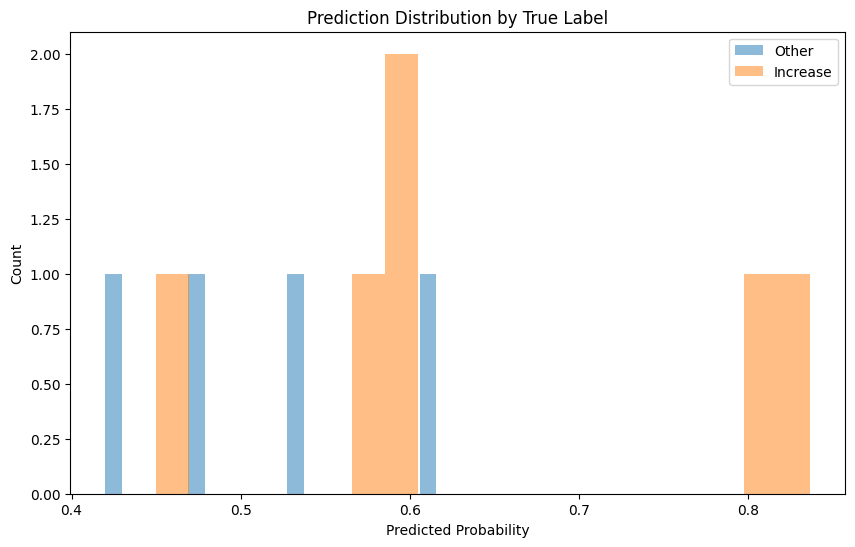

In [24]:
import matplotlib.pyplot as plt

def plot_probability_distribution(q_classifier, X, y):
    """Visualize prediction distributions"""
    probs = [q_classifier.predict_proba(x1, x2) for x1, x2 in X]
    
    plt.figure(figsize=(10,6))
    for label in [0, 1]:
        plt.hist([p for p, l in zip(probs, y) if l == label], 
                 alpha=0.5, bins=20, label=["Other", "Increase"][label])
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title("Prediction Distribution by True Label")
    plt.legend()
    plt.show()

plot_probability_distribution(q_classifier, X, y)